In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
import pandas as pd

data = pd.read_csv("/content/gdrive/My Drive/corona_test/corona_tested_individuals_ver_006.english.csv")
data = data.astype(str)
print(data.shape)
data

Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.


(278848, 10)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other
...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,negative,None,None,Other
278844,2020-03-11,0,0,0,0,0,negative,None,None,Other
278845,2020-03-11,0,0,0,0,0,positive,None,None,Contact with confirmed
278846,2020-03-11,0,0,0,0,0,other,None,None,Other


In [35]:
data = data.loc[(data["corona_result"]!='other')&(data["age_60_and_above"]!="None")&(data["gender"]!="None")]
data = data.iloc[:100000,:]

In [36]:
# filter bias symptoms

data = data[["cough", "fever", "corona_result", "age_60_and_above", "gender", "test_indication"]]
data = data.dropna()
data

,cough,fever,corona_result,age_60_and_above,gender,test_indication
122808,1,0,negative,Yes,male,Other
122809,1,0,positive,No,female,Other
122810,0,0,negative,No,female,Other
122811,0,1,negative,No,female,Abroad
122812,1,0,negative,Yes,female,Other
...,...,...,...,...,...,...
226905,0,0,negative,Yes,male,Other
226906,0,0,negative,No,male,Other
226907,0,0,negative,No,female,Other
226908,0,0,negative,No,female,Other


In [37]:
data.dtypes

cough               object
fever               object
corona_result       object
age_60_and_above    object
gender              object
test_indication     object
dtype: object

In [38]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data.iloc[:,:] = ord_enc.fit_transform(data.iloc[:,:])
data.head(5)

,cough,fever,corona_result,age_60_and_above,gender,test_indication
122808,1.0,0.0,0.0,1.0,1.0,2.0
122809,1.0,0.0,1.0,0.0,0.0,2.0
122810,0.0,0.0,0.0,0.0,0.0,2.0
122811,0.0,1.0,0.0,0.0,0.0,0.0
122812,1.0,0.0,0.0,1.0,0.0,2.0


In [39]:
data = data.astype(int)
X = data[["cough","fever","age_60_and_above","gender","test_indication"]]
y = data[["corona_result"]]

In [40]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [41]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
model = clf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [42]:
# predict the results
y_pred= model.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f} %'.format(accuracy_score(y_test, y_pred)*100))

LightGBM Model accuracy score: 94.4800 %


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 8.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=8ecb2f097136884af00a8bb466cb1f576c1e721cbc3e46a69f44df93743fcff5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [43]:
import shap
# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 99816/100000 [03:09<00:00]       

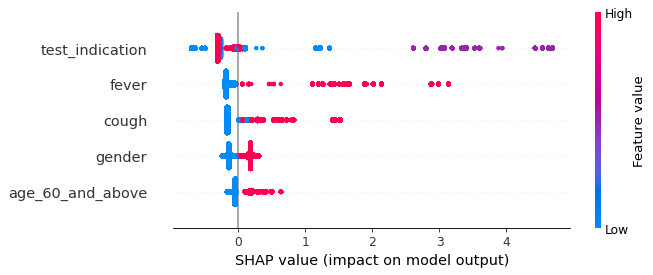

In [44]:
#plt.style.use('default')
plt.figure(figsize=(20, 10), dpi=80)
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("100000-shap.png", bbox_inches='tight', dpi=300)

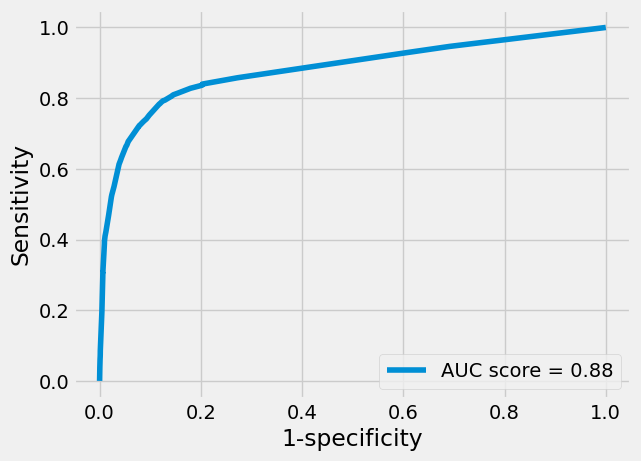

In [45]:
# ROC curve

from sklearn import metrics
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC score = %.2f"%auc)
plt.xlabel("1-specificity")
plt.ylabel("Sensitivity")
plt.legend(loc="lower right")
plt.savefig("100000-ROC.png", dpi=500)
#plt.show()